<a href="https://colab.research.google.com/github/salmanromeo/System_Identification/blob/main/Bayesian_Probabilistic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install texlive-fonts-recommended
!apt-get install texlive-fonts-extra
!apt-get install dvipng
!apt-get install cm-super

In [ ]:
pip install pyro-ppl

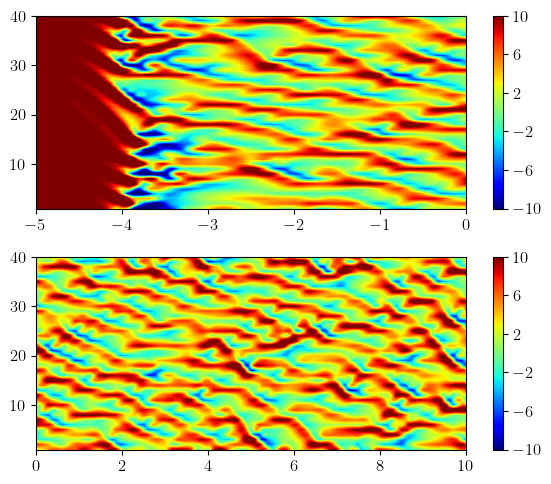

[9, 19, 29, 39]


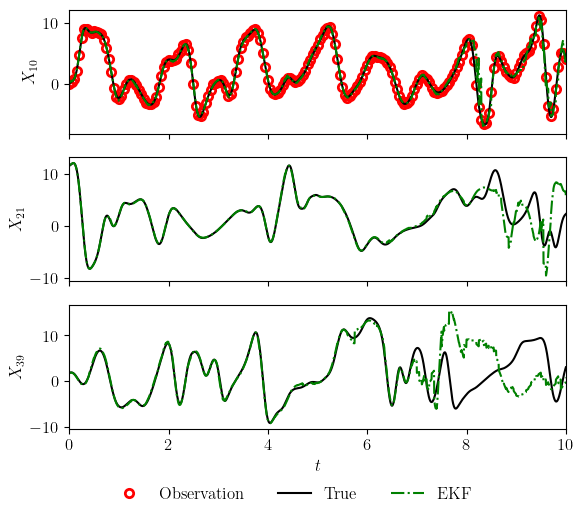

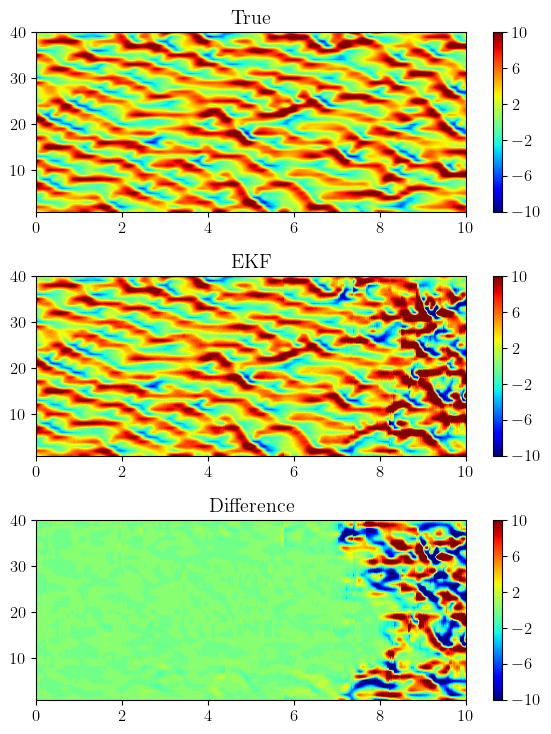

1049.552441845801


In [77]:
import numpy as np
from numpy.random import seed
seed(22)
from scipy import integrate
from scipy import linalg
import matplotlib.pyplot as plt
import time as tm
import matplotlib.ticker as ticker

font = {'family' : 'Times New Roman',
        'size'   : 12}
plt.rc('font', **font)

import matplotlib as mpl
%matplotlib inline

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

#%%
def rhs(ne,u,fr):
    v = np.zeros(ne+3)
    v[2:ne+2] = u
    v[1] = v[ne+1]
    v[0] = v[ne]
    v[ne+2] = v[2]

    r = np.zeros(ne)

    r = v[1:ne+1]*(v[3:ne+3] - v[0:ne]) - v[2:ne+2] + fr

    return r

def jacrhs(ne,u):
    #first: set zero elements
    jf = np.zeros((ne,ne))

    #second: set non-zero elements with periodic bc (it is sparse)
    jf[0,0] = -1.0
    jf[0,1] = u[ne-1]
    jf[0,ne-2] = -u[ne-1]
    jf[0,ne-2] = -u[ne-2]

    jf[1,0] = u[2] - u[ne-1]
    jf[1,1] = -1.0
    jf[1,2] = u[0]
    jf[1,ne-1] = -u[0]

    jf[ne-1,0] = u[ne-2]
    jf[ne-1,ne-3] = -u[ne-2]
    jf[ne-1,ne-2] = u[0] - u[ne-3]
    jf[ne-1,ne-1] = -1.0

    #third: set non-zero elements for internal points (it is sparse)
    for i in range(2,ne-1):
        jf[i,i-2] = -u[i-1]
        jf[i,i-1] = u[i+1] - u[i-2]
        jf[i,i] = -1.0
        jf[i,i+1] = u[i-1]

    return jf

def jacrks4(ne,u,dt):
    jf = jacrhs(ne,u)
    jf2 = jf @ jf
    jf3 = jf2 @ jf
    jf4 = jf3 @ jf

    dm = np.eye(ne) + dt*jf + 0.5*dt**2*jf2 + (1.0/6.0)*(dt**3)*jf3 + (1.0/24.0)*(dt**4)*jf4

    return dm

def rk4(ne,dt,u,fr):
    r1 = rhs(ne,u,fr)
    k1 = dt*r1

    r2 = rhs(ne,u+0.5*k1,fr)
    k2 = dt*r2

    r3 = rhs(ne,u+0.5*k2,fr)
    k3 = dt*r3

    r4 = rhs(ne,u+k3,fr)
    k4 = dt*r4

    un = u + (k1 + 2.0*(k2 + k3) + k4)/6.0

    return un

#%%
ne = 40
dt = 0.005
tmax = 10.0
tini = 5.0
ns = int(tini/dt)
nt = int(tmax/dt)
fr = 10.0
nf = 10         # frequency of observation
nb = int(nt/nf) # number of observation time

u = np.zeros(ne)
utrue = np.zeros((ne,nt+1))
uinit = np.zeros((ne,ns+1))

#-----------------------------------------------------------------------------#
# generate true solution trajectory
#-----------------------------------------------------------------------------#
ti = np.linspace(-tini,0,ns+1)
t = np.linspace(0,tmax,nt+1)
tobs = np.linspace(0,tmax,nb+1)
x = np.linspace(1,ne,ne)

X,T = np.meshgrid(x,t,indexing='ij')
Xi,Ti = np.meshgrid(x,ti,indexing='ij')

u[:] = fr
u[int(ne/2)-1] = fr + 0.01
uinit[:,0] = u

# generate initial condition at t = 0
for k in range(1,ns+1):
    un = rk4(ne,dt,u,fr)
    uinit[:,k] = un
    u = np.copy(un)

# assign inital condition
u = uinit[:,-1]
utrue[:,0] = uinit[:,-1]

# generate true forward solution
for k in range(1,nt+1):
    un = rk4(ne,dt,u,fr)
    utrue[:,k] = un
    u = np.copy(un)

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(2,1,figsize=(6,5))
cs = ax[0].contourf(Ti,Xi,uinit,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(uinit)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

cs = ax[1].contourf(T,X,utrue,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

#%%
#-----------------------------------------------------------------------------#
# generate observations
#-----------------------------------------------------------------------------#
mean = 0.0
sd2 = 1.0e-2 # added observation noise (variance)
sd1 = np.sqrt(sd2) # added noise (standard deviation)

oib = [nf*k for k in range(nb+1)]

uobs = utrue[:,oib] + np.random.normal(mean,sd1,[ne,nb+1])

#-----------------------------------------------------------------------------#
# generate erroneous soltions trajectory
#-----------------------------------------------------------------------------#
uw = np.zeros((ne,nt+1))
k = 0
si2 = 1.0e-2
si1 = np.sqrt(si2)

u = utrue[:,0] + np.random.normal(mean,si1,ne)
uw[:,0] = u

for k in range(1,nt+1):
    un = rk4(ne,dt,u,fr)
    uw[:,k] = un
    u = np.copy(un)

#%%
#-----------------------------------------------------------------------------#
# EnKF model
#-----------------------------------------------------------------------------#

# number of observation vector
me = 4
freq = int(ne/me)
oin = [freq*i-1 for i in range(1,me+1)]
roin = np.int32(np.linspace(0,me-1,me))
print(oin)

#%%
z = np.zeros((me,nb+1))

ua = np.zeros((ne,nt+1)) # analysis solution (to store)
pa = np.zeros((ne,ne)) # analysis covariance
pf = np.zeros((ne,ne)) # forecast covariance
uf = np.zeros(ne)        # forecast

km = np.zeros((ne,me))

z[:,:] = uobs[oin,:]

# initial ensemble
k = 0
se2 = 1e-4 #np.sqrt(sd2)
se1 = np.sqrt(se2)

Q = se2 * np.eye(ne)
R = sd2 * np.eye(me)

u = uw[:,k] #+ np.random.normal(mean,si1,ne)
ua[:,k] = u

# initial estimate of the analysis covariance
pa = si2 * np.eye(ne)

dh = np.zeros((me,ne))
dh[roin,oin] = 1.0

#%%
kobs = 1

# RK4 scheme
for k in range(1,nt+1):

    # forecast field
    uf = rk4(ne,dt,u,fr)

    dm = jacrks4(ne,u,dt)

    # forecast covariance
    pf = dm @ pa @ dm.T + Q
    pf = 0.5*(pf + pf.T)
    pa = np.copy(pf)

    # perform analysis at observation points
    if k == oib[kobs]:
        dm = jacrks4(ne,u,dt)

        # forecast covariance
#        pf = dm @ pa @ dm.T + Q
#
#        pf = 0.5*(pf + pf.T)

        cc = dh @ pf @ dh.T + R
        ci = np.linalg.pinv(cc)

        cc_ch = np.linalg.cholesky(cc)

        ph = pf @ dh.T

        # compute Kalman gain
        km = ph @ ci

        # analysis update
        kmd = km @ (z[:,kobs] - uf[oin])
        uf = uf + kmd

        # compute analysis covaraince
        kd = np.eye(ne) - km @ dh
        pa = kd @ pf

        kobs = kobs+1

    # mean analysis for plotting
    ua[:,k] = uf
    u = np.copy(uf)

#%%
np.savez('data_'+str(me)+'.npz',t=t,tobs=tobs,T=T,X=X,utrue=utrue,uobs=uobs,uw=uw,ua=ua,oin=oin)

#%%
fig, ax = plt.subplots(3,1,sharex=True,figsize=(6,5))

n = [9,20,38]
for i in range(3):
    if i == 0:
        ax[i].plot(tobs,uobs[n[i],:],'ro',fillstyle='none', markersize=6,markeredgewidth=2)
    ax[i].plot(t,utrue[n[i],:],'k-')
    #ax[i].plot(t,uw[n[i],:],'b--')
    ax[i].plot(t,ua[n[i],:],'g-.')


    ax[i].set_xlim([0,tmax])
    ax[i].set_ylabel(r'$X_{'+str(n[i]+1)+'}$')

ax[i].set_xlabel(r'$t$')
line_labels = ['Observation','True','EKF']
plt.figlegend( line_labels,  loc = 'lower center', borderaxespad=-0.2, ncol=4, labelspacing=0., frameon=False)
fig.tight_layout()
plt.show()
fig.savefig('m_'+str(me)+'.pdf')

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(3,1,figsize=(6,7.5))

cs = ax[0].contourf(T,X,utrue,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))
ax[0].set_title('True')

cs = ax[1].contourf(T,X,ua,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(ua)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))
ax[1].set_title('EKF')

diff = ua - utrue
cs = ax[2].contourf(T,X,diff,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(diff)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))
ax[2].set_title('Difference')

fig.tight_layout()
plt.show()
fig.savefig('f1_'+str(me)+'.pdf')

#%%
print(np.linalg.norm(diff))

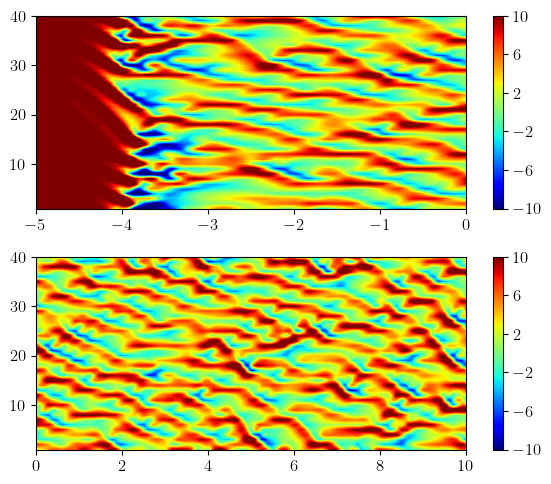

[9, 19, 29, 39]


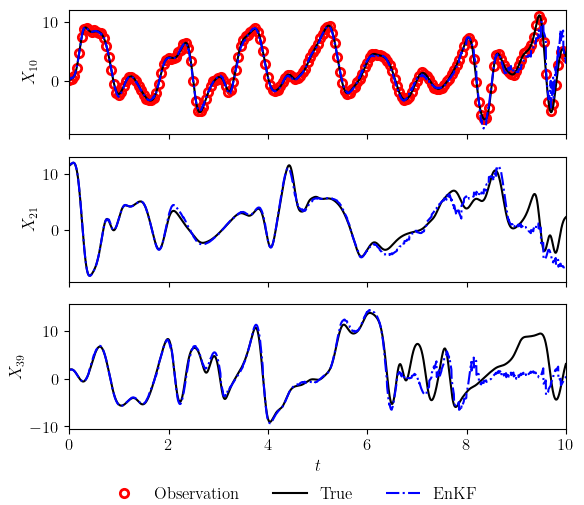

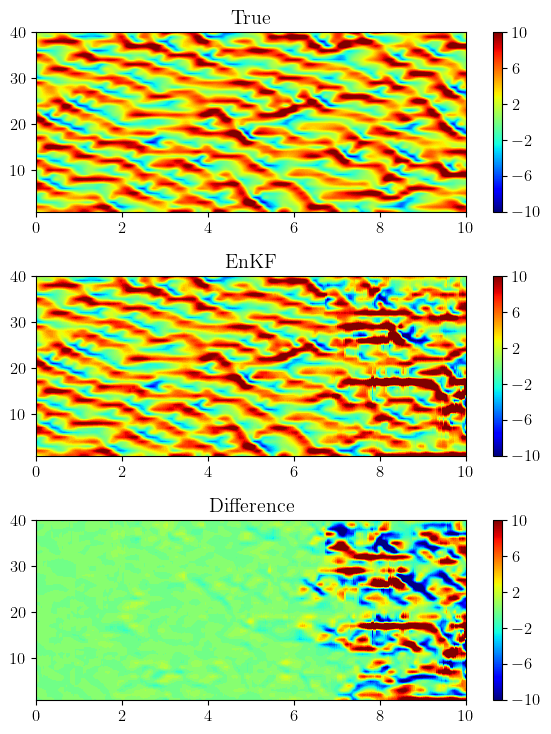

1089.5609906924522


In [78]:
import numpy as np
from numpy.random import seed
seed(22)
from scipy import integrate
from scipy import linalg
import matplotlib.pyplot as plt
import time as tm
import matplotlib.ticker as ticker

font = {'family' : 'Times New Roman',
        'size'   : 12}
plt.rc('font', **font)

import matplotlib as mpl
%matplotlib inline

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

#%%
def rhs(ne,u,fr):
    v = np.zeros(ne+3)
    v[2:ne+2] = u
    v[1] = v[ne+1]
    v[0] = v[ne]
    v[ne+2] = v[2]

    r = np.zeros(ne)

#    for i in range(2,ne+2):
#        r[i-2] = v[i-1]*(v[i+1] - v[i-2]) - v[i] + fr

    r = v[1:ne+1]*(v[3:ne+3] - v[0:ne]) - v[2:ne+2] + fr

    return r


def rk4(ne,dt,u,fr):
    r1 = rhs(ne,u,fr)
    k1 = dt*r1

    r2 = rhs(ne,u+0.5*k1,fr)
    k2 = dt*r2

    r3 = rhs(ne,u+0.5*k2,fr)
    k3 = dt*r3

    r4 = rhs(ne,u+k3,fr)
    k4 = dt*r4

    un = u + (k1 + 2.0*(k2 + k3) + k4)/6.0

    return un

#%%
ne = 40

dt = 0.005
tmax = 10.0
tini = 5.0
ns = int(tini/dt)
nt = int(tmax/dt)
fr = 10.0
nf = 10         # frequency of observation
nb = int(nt/nf) # number of observation time

u = np.zeros(ne)
utrue = np.zeros((ne,nt+1))
uinit = np.zeros((ne,ns+1))

#-----------------------------------------------------------------------------#
# generate true solution trajectory
#-----------------------------------------------------------------------------#
ti = np.linspace(-tini,0,ns+1)
t = np.linspace(0,tmax,nt+1)
tobs = np.linspace(0,tmax,nb+1)
x = np.linspace(1,ne,ne)

X,T = np.meshgrid(x,t,indexing='ij')
Xi,Ti = np.meshgrid(x,ti,indexing='ij')

u[:] = fr
u[int(ne/2)-1] = fr + 0.01
uinit[:,0] = u

# generate initial condition at t = 0
for k in range(1,ns+1):
    un = rk4(ne,dt,u,fr)
    uinit[:,k] = un
    u = np.copy(un)

# assign inital condition
u = uinit[:,-1]
utrue[:,0] = uinit[:,-1]

# generate true forward solution
for k in range(1,nt+1):
    un = rk4(ne,dt,u,fr)
    utrue[:,k] = un
    u = np.copy(un)

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(2,1,figsize=(6,5))
cs = ax[0].contourf(Ti,Xi,uinit,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(uinit)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

cs = ax[1].contourf(T,X,utrue,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

#%%
#-----------------------------------------------------------------------------#
# generate observations
#-----------------------------------------------------------------------------#
mean = 0.0
sd2 = 1.0e-2 # added noise (variance)
sd1 = np.sqrt(sd2) # added noise (standard deviation)

oib = [nf*k for k in range(nb+1)]

uobs = utrue[:,oib] + np.random.normal(mean,sd1,[ne,nb+1])

#-----------------------------------------------------------------------------#
# generate erroneous soltions trajectory
#-----------------------------------------------------------------------------#
uw = np.zeros((ne,nt+1))
k = 0
si2 = 1.0e-2
si1 = np.sqrt(si2)

u = utrue[:,0] + np.random.normal(mean,si1,ne)
uw[:,0] = u

for k in range(1,nt+1):
    un = rk4(ne,dt,u,fr)
    uw[:,k] = un
    u = np.copy(un)

#%%
#-----------------------------------------------------------------------------#
# EnKF model
#-----------------------------------------------------------------------------#

# number of observation vector
me = 4
freq = int(ne/me)
oin = [freq*i-1 for i in range(1,me+1)]
print(oin)

#%%
# number of ensemble
npe = 40
cn = 1.0/np.sqrt(npe-1)

z = np.zeros((me,nb+1))
zf = np.zeros((me,npe,nb+1))
DhX = np.zeros((me,npe))
DhXm = np.zeros(me)

ua = np.zeros((ne,nt+1)) # mean analyssi solution (to store)
uf = np.zeros(ne)        # mean forecast
sc = np.zeros((ne,npe))   # square-root of the covariance matrix
ue = np.zeros((ne,npe,nt+1)) # all ensambles
ph = np.zeros((ne,me))

km = np.zeros((ne,me))
kmd = np.zeros((ne,npe))

cc = np.zeros((me,me))
ci = np.zeros((me,me))

for k in range(nb+1):
    z[:,k] = uobs[oin,k]
    for n in range(npe):
        zf[:,n,k] = z[:,k] + np.random.normal(mean,sd1,me)

# initial ensemble
k = 0
se2 = 1.0e-4 #np.sqrt(sd2)
se1 = np.sqrt(se2)

for n in range(npe):
    ue[:,n,k] = uw[:,k] + np.random.normal(mean,si1,ne)

ua[:,k] = np.sum(ue[:,:,k],axis=1)
ua[:,k] = ua[:,k]/npe

kobs = 1

# RK4 scheme
for k in range(1,nt+1):

    # forecast afor all ensemble fields
    for n in range(npe):
        u[:] = ue[:,n,k-1]
        un = rk4(ne,dt,u,fr)
        ue[:,n,k] = un[:] + np.random.normal(mean,se1,ne)

    if k == oib[kobs]:
        # compute mean of the forecast fields
        uf[:] = np.sum(ue[:,:,k],axis=1)
        uf[:] = uf[:]/npe

        # compute square-root of the covariance matrix
        for n in range(npe):
            sc[:,n] = cn*(ue[:,n,k] - uf[:])

        # compute DhXm data
        DhXm[:] = np.sum(ue[oin,:,k],axis=1)
        DhXm[:] = DhXm[:]/npe

        # compute DhM data
        for n in range(npe):
            DhX[:,n] = cn*(ue[oin,n,k] - DhXm[:])

        # R = sd2*I, observation m+atrix
        cc = DhX @ DhX.T

        for i in range(me):
            cc[i,i] = cc[i,i] + sd2

        ph = sc @ DhX.T

        ci = np.linalg.pinv(cc) # ci: inverse of cc matrix

        km = ph @ ci

        # analysis update
        kmd = km @ (zf[:,:,kobs] - ue[oin,:,k])
        ue[:,:,k] = ue[:,:,k] + kmd[:,:]

        kobs = kobs+1

    # mean analysis for plotting
    ua[:,k] = np.sum(ue[:,:,k],axis=1)
    ua[:,k] = ua[:,k]/npe

np.savez('data_'+str(me)+'.npz',t=t,tobs=tobs,T=T,X=X,utrue=utrue,uobs=uobs,uw=uw,ua=ua,oin=oin)

#%%
fig, ax = plt.subplots(3,1,sharex=True,figsize=(6,5))

n = [9,20,38]
for i in range(3):
    if i == 0:
      ax[i].plot(tobs,uobs[n[i],:],'ro',fillstyle='none', markersize=6,markeredgewidth=2)
    ax[i].plot(t,utrue[n[i],:],'k-')
    #ax[i].plot(t,uw[n[i],:],'b--')
    ax[i].plot(t,ua[n[i],:],'b-.')

    ax[i].set_xlim([0,tmax])
    ax[i].set_ylabel(r'$X_{'+str(n[i]+1)+'}$')

ax[i].set_xlabel(r'$t$')
line_labels = ['Observation','True','EnKF']
plt.figlegend( line_labels,  loc = 'lower center', borderaxespad=-0.2, ncol=4, labelspacing=0., frameon=False)
fig.tight_layout()
plt.show()
fig.savefig('m_'+str(me)+'.pdf')

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(3,1,figsize=(6,7.5))

cs = ax[0].contourf(T,X,utrue,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))
ax[0].set_title('True')

cs = ax[1].contourf(T,X,ua,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(ua)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))
ax[1].set_title('EnKF')

diff = ua - utrue
cs = ax[2].contourf(T,X,diff,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(ua)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))
ax[2].set_title('Difference')

fig.tight_layout()
plt.show()
fig.savefig('f_'+str(me)+'.pdf')

#%%
print(np.linalg.norm(diff))

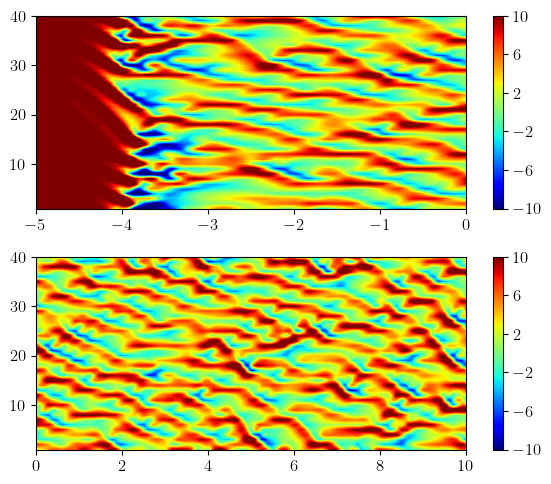

[9, 19, 29, 39]


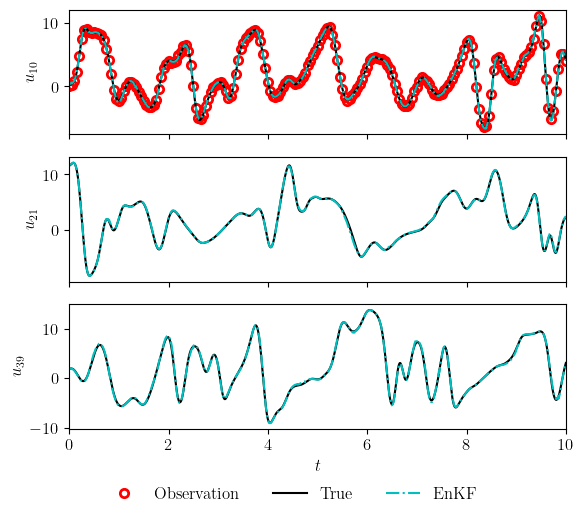

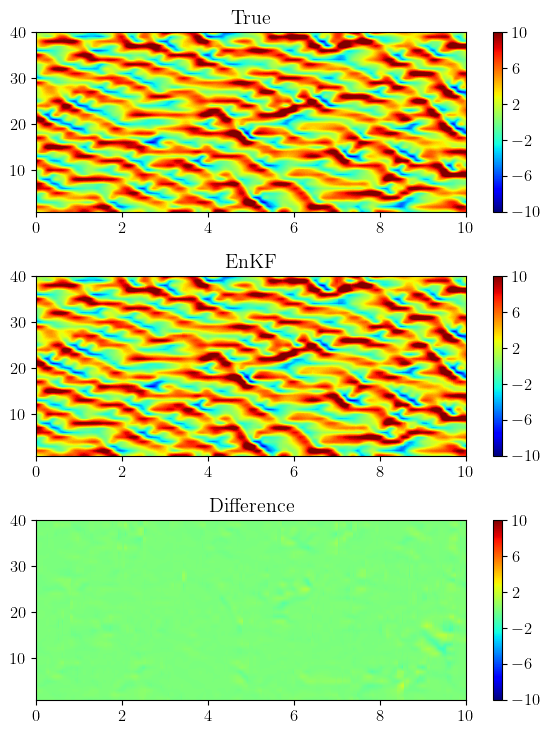

53.671818632169966


In [61]:
import numpy as np
from numpy.random import seed
seed(22)
from scipy import integrate
from scipy import linalg
import matplotlib.pyplot as plt
import time as tm
import matplotlib.ticker as ticker

font = {'family' : 'Times New Roman',
        'size'   : 12}
plt.rc('font', **font)

import matplotlib as mpl
%matplotlib inline

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

#%%
def rhs(ne,u,fr):
    v = np.zeros(ne+3)
    v[2:ne+2] = u
    v[1] = v[ne+1]
    v[0] = v[ne]
    v[ne+2] = v[2]

    r = np.zeros(ne)

#    for i in range(2,ne+2):
#        r[i-2] = v[i-1]*(v[i+1] - v[i-2]) - v[i] + fr

    r = v[1:ne+1]*(v[3:ne+3] - v[0:ne]) - v[2:ne+2] + fr

    return r


def rk4(ne,dt,u,fr):
    r1 = rhs(ne,u,fr)
    k1 = dt*r1

    r2 = rhs(ne,u+0.5*k1,fr)
    k2 = dt*r2

    r3 = rhs(ne,u+0.5*k2,fr)
    k3 = dt*r3

    r4 = rhs(ne,u+k3,fr)
    k4 = dt*r4

    un = u + (k1 + 2.0*(k2 + k3) + k4)/6.0

    return un

#%%
ne = 40

dt = 0.005
tmax = 10.0
tini = 5.0
ns = int(tini/dt)
nt = int(tmax/dt)
fr = 10.0
nf = 10         # frequency of observation
nb = int(nt/nf) # number of observation time

u = np.zeros(ne)
utrue = np.zeros((ne,nt+1))
uinit = np.zeros((ne,ns+1))

#-----------------------------------------------------------------------------#
# generate true solution trajectory
#-----------------------------------------------------------------------------#
ti = np.linspace(-tini,0,ns+1)
t = np.linspace(0,tmax,nt+1)
tobs = np.linspace(0,tmax,nb+1)
x = np.linspace(1,ne,ne)

X,T = np.meshgrid(x,t,indexing='ij')
Xi,Ti = np.meshgrid(x,ti,indexing='ij')

u[:] = fr
u[int(ne/2)-1] = fr + 0.01
uinit[:,0] = u

# generate initial condition at t = 0
for k in range(1,ns+1):
    un = rk4(ne,dt,u,fr)
    uinit[:,k] = un
    u = np.copy(un)

# assign inital condition
u = uinit[:,-1]
utrue[:,0] = uinit[:,-1]

# generate true forward solution
for k in range(1,nt+1):
    un = rk4(ne,dt,u,fr)
    utrue[:,k] = un
    u = np.copy(un)

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(2,1,figsize=(6,5))
cs = ax[0].contourf(Ti,Xi,uinit,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(uinit)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

cs = ax[1].contourf(T,X,utrue,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

#%%
#-----------------------------------------------------------------------------#
# generate observations
#-----------------------------------------------------------------------------#
mean = 0.0
sd2 = 1.0e-2 # added noise (variance)
sd1 = np.sqrt(sd2) # added noise (standard deviation)

oib = [nf*k for k in range(nb+1)]

uobs = utrue[:,oib] + np.random.normal(mean,sd1,[ne,nb+1])

#-----------------------------------------------------------------------------#
# generate erroneous soltions trajectory
#-----------------------------------------------------------------------------#
uw = np.zeros((ne,nt+1))
k = 0
si2 = 1.0e-2
si1 = np.sqrt(si2)

u = utrue[:,0] + np.random.normal(mean,si1,ne)
uw[:,0] = u

for k in range(1,nt+1):
    un = rk4(ne,dt,u,fr)
    uw[:,k] = un
    u = np.copy(un)

#%%
#-----------------------------------------------------------------------------#
# EnKF model
#-----------------------------------------------------------------------------#

# number of observation vector
me = 4
freq = int(ne/me)
oin = [freq*i-1 for i in range(1,me+1)]
roin = np.int32(np.linspace(0,me-1,me))
print(oin)

dh = np.zeros((me,ne))
dh[roin,oin] = 1.0

H = np.zeros((me,ne))
H[roin,oin] = 1.0

#%%
# number of ensemble
npe = 200
cn = 1.0/np.sqrt(npe-1)
lambd = 1.0

z = np.zeros((me,nb+1))
#zf = np.zeros((me,npe,nb+1))
DhX = np.zeros((me,npe))
DhXm = np.zeros(me)

ua = np.zeros((ne,nt+1)) # mean analyssi solution (to store)
uf = np.zeros(ne)        # mean forecast
sc = np.zeros((ne,npe))   # square-root of the covariance matrix
Af = np.zeros((ne,npe))   # Af data
ue = np.zeros((ne,npe,nt+1)) # all ensambles
ph = np.zeros((ne,me))

km = np.zeros((ne,me))
kmd = np.zeros((ne,npe))

cc = np.zeros((me,me))
ci = np.zeros((me,me))

for k in range(nb+1):
    z[:,k] = uobs[oin,k]
#    for n in range(npe):
#        zf[:,n,k] = z[:,k] + np.random.normal(mean,sd1,me)

#%%
# initial ensemble
k = 0
se2 = 0.0 #np.sqrt(sd2)
se1 = np.sqrt(se2)

for n in range(npe):
    ue[:,n,k] = uw[:,k] + np.random.normal(mean,si1,ne)

ua[:,k] = np.sum(ue[:,:,k],axis=1)
ua[:,k] = ua[:,k]/npe

kobs = 1

# RK4 scheme
for k in range(1,nt+1):

    # forecast afor all ensemble fields
    for n in range(npe):
        u[:] = ue[:,n,k-1]
        un = rk4(ne,dt,u,fr)
        ue[:,n,k] = un[:] #+ np.random.normal(mean,se1,ne)

    # mean analysis for plotting
    ua[:,k] = np.sum(ue[:,:,k],axis=1)
    ua[:,k] = ua[:,k]/npe

    if k == oib[kobs]:
        # compute mean of the forecast fields
        uf[:] = np.sum(ue[:,:,k],axis=1)
        uf[:] = uf[:]/npe

        # compute Af dat
        for n in range(npe):
            Af[:,n] = ue[:,n,k] - uf[:]

        pf = Af @ Af.T
        pf[:,:] = pf[:,:]/(npe-1)

        dp = dh @ pf
        cc = dp @ dh.T

        for i in range(me):
            cc[i,i] = cc[i,i] + sd2

        ph = pf @ dh.T

        ci = np.linalg.pinv(cc) # ci: inverse of cc matrix

        km = ph @ ci # compute Kalman gain

        # analysis update
        kmd = km @ (z[:,kobs] - uf[oin])
        ua[:,k] = uf[:] + kmd[:]

        # ensemble correction
        ha = dh @ Af

        ue[:,:,k] = Af[:,:] - 0.5*(km @ dh @ Af) + ua[:,k].reshape(-1,1)

        #multiplicative inflation (optional): set lambda=1.0 for no inflation
        #ue[:,:,k] = ua[:,k] + lambd*(ue[:,:,k] - ua[:,k])

        kobs = kobs+1

np.savez('data_'+str(me)+'.npz',t=t,tobs=tobs,T=T,X=X,utrue=utrue,uobs=uobs,uw=uw,ua=ua,oin=oin)

#%%
fig, ax = plt.subplots(3,1,sharex=True,figsize=(6,5))

n = [9,20,38]
for i in range(3):
    if i == 0:
        ax[i].plot(tobs,uobs[n[i],:],'ro',fillstyle='none', markersize=6,markeredgewidth=2)
    ax[i].plot(t,utrue[n[i],:],'k-')
    #ax[i].plot(t,uw[n[i],:],'b--')
    ax[i].plot(t,ua[n[i],:],'c-.')

    ax[i].set_xlim([0,tmax])
    ax[i].set_ylabel(r'$X_{'+str(n[i]+1)+'}$')

ax[i].set_xlabel(r'$t$')
line_labels = ['Observation','True','EnKF']
plt.figlegend( line_labels,  loc = 'lower center', borderaxespad=-0.2, ncol=4, labelspacing=0., frameon=False)
fig.tight_layout()
plt.show()
fig.savefig('m_'+str(me)+'.pdf')

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(3,1,figsize=(6,7.5))

cs = ax[0].contourf(T,X,utrue,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))
ax[0].set_title('True')

cs = ax[1].contourf(T,X,ua,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(ua)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))
ax[1].set_title('EnKF')

diff = ua - utrue
cs = ax[2].contourf(T,X,diff,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(ua)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))
ax[2].set_title('Difference')

fig.tight_layout()
plt.show()
fig.savefig('f_'+str(me)+'.pdf')

print(np.linalg.norm(diff))

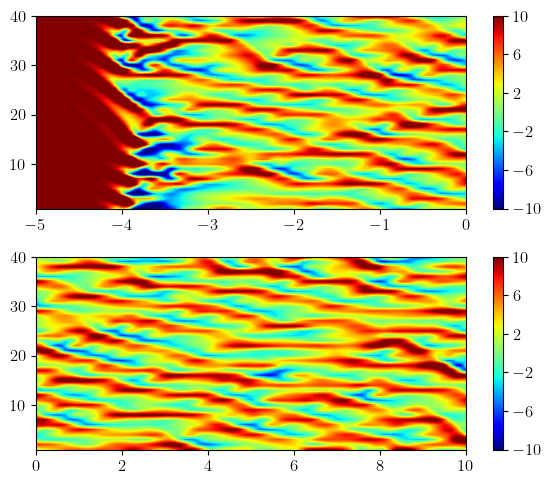

Sample: 100%|██████████| 2000/2000 [08:39,  3.85it/s, step size=5.66e-02, acc. prob=0.928]


Estimated parameters: tensor([ 9.9125e+00,  8.6829e-03,  1.3824e-03, -9.9436e-01,  2.3715e-02,
         7.3043e-03, -1.0004e+00, -1.9871e-04, -1.5309e-03, -8.9153e-04,
         1.5730e-05,  9.9998e-01,  7.4014e-04, -2.5649e-04, -4.6161e-04,
        -3.9753e-04,  1.0985e-04,  2.1179e-04, -4.5344e-04, -1.3540e-03,
         2.7512e-04], dtype=torch.float64)


In [3]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
import numpy as np
from numpy.random import seed
seed(22)
from scipy import integrate
from scipy import linalg
import matplotlib.pyplot as plt
import time as tm
import matplotlib.ticker as ticker
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

font = {'family' : 'Times New Roman',
        'size'   : 12}
plt.rc('font', **font)

import matplotlib as mpl
%matplotlib inline

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

#%%
def rhs(ne,u,fr):
    v = np.zeros(ne+3)
    v[2:ne+2] = u
    v[1] = v[ne+1]
    v[0] = v[ne]
    v[ne+2] = v[2]

    r = np.zeros(ne)

    r = v[1:ne+1]*(v[3:ne+3] - v[0:ne]) - v[2:ne+2] + fr

    return r


def rk4(ne,dt,u,fr):
    r1 = rhs(ne,u,fr)
    k1 = dt*r1

    r2 = rhs(ne,u+0.5*k1,fr)
    k2 = dt*r2

    r3 = rhs(ne,u+0.5*k2,fr)
    k3 = dt*r3

    r4 = rhs(ne,u+k3,fr)
    k4 = dt*r4

    un = u + (k1 + 2.0*(k2 + k3) + k4)/6.0

    return un

#%%
ne = 40

dt = 0.005
tmax = 10.0
tini = 5.0
ns = int(tini/dt)
nt = int((tmax-tini)/dt)
fr = 10.0
nf = 10         # frequency of observation
nb = int(nt/nf) # number of observation time

u = np.zeros(ne)
utrue = np.zeros((ne,nt))
uinit = np.zeros((ne,ns))

#-----------------------------------------------------------------------------#
# generate true solution trajectory
#-----------------------------------------------------------------------------#
ti = np.linspace(-tini,0,ns)
t = np.linspace(0,tmax,nt)
tobs = np.linspace(0,tmax,nb)
x = np.linspace(1,ne,ne)

X,T = np.meshgrid(x,t,indexing='ij')
Xi,Ti = np.meshgrid(x,ti,indexing='ij')

u[:] = fr
u[int(ne/2)-1] = fr + 0.01
uinit[:,0] = u

# generate initial condition at t = 0
for k in range(1,ns):
    un = rk4(ne,dt,u,fr)
    uinit[:,k] = un
    u = np.copy(un)

# assign inital condition
u = uinit[:,-1]
utrue[:,0] = uinit[:,-1]

# generate true forward solution
for k in range(1,nt):
    un = rk4(ne,dt,u,fr)
    utrue[:,k] = un
    u = np.copy(un)

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(2,1,figsize=(6,5))
cs = ax[0].contourf(Ti,Xi,uinit,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(uinit)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

cs = ax[1].contourf(T,X,utrue,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

x_solution = torch.from_numpy(utrue.T)
X_state = x_solution

# True RHS
N = 40
F = 10
RHS_true = torch.zeros((nt, N))
for k in range(N):
    RHS_true[:,k]=(x_solution[:,(k + 1) % N] - x_solution[:,(k - 2)% N]) * x_solution[:,(k - 1)% N] - x_solution[:,k] + F

dx_dt_state = RHS_true  # True RHS

# Define the assumed dynamics:
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

# Set the observed data
X_observed = np.vstack([
    X_state[:, (k - 2) % N].numpy(),
    X_state[:, (k - 1) % N].numpy(),
    X_state[:, k].numpy(),
    X_state[:, (k + 1) % N].numpy(),
    X_state[:, (k + 2) % N].numpy(),
]).T
Y_observed = dx_dt_state[:, k].numpy()

# Convert the observed data to PyTorch tensors
X_observed = torch.tensor(X_observed)
Y_observed = torch.tensor(Y_observed)

# Define the Pyro model
def model(X_observed, Y_observed):
    N_P = 21  # Number of parameters
    d = pyro.sample("d", dist.Normal(torch.zeros(N_P), 2 * torch.ones(N_P)))
    mu = func(X_observed.T, d)
    pyro.sample("Y", dist.Normal(mu, 1.0), obs=Y_observed)

# Perform Bayesian inference with MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(X_observed, Y_observed)

# Get the posterior samples
posterior_samples = mcmc.get_samples()
estimated_params = posterior_samples["d"].mean(dim=0)
print("Estimated parameters:", estimated_params)

# Use the estimated parameter values
estimated_params = posterior_samples["d"].mean(axis=0).numpy()

# Define the assumed dynamics with estimated parameter values
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

# Calculate the estimated RHS
RHS_estimated = torch.zeros((nt, N))
for k in range(N):
    RHS_estimated[:, k] = func(
        torch.stack([
            X_state[:, (k - 2) % N],
            X_state[:, (k - 1) % N],
            X_state[:, k],
            X_state[:, (k + 1) % N],
            X_state[:, (k + 2) % N]
        ]),
        estimated_params
    )

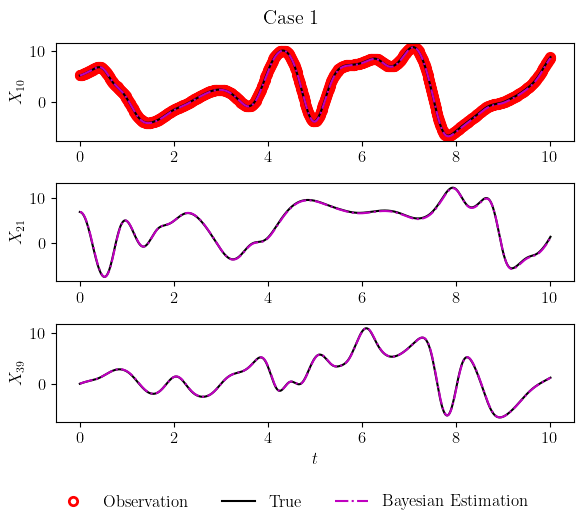

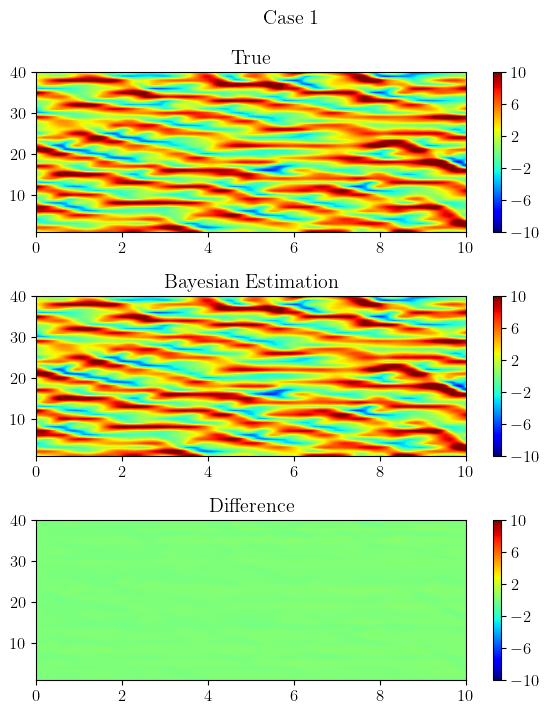

In [5]:
t_steps = torch.linspace(0, 10, 1000)
# Use the estimated parameter values
estimated_params = posterior_samples["d"].mean(axis=0).numpy()

# Define the assumed dynamics with estimated parameter values
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

# Calculate the estimated RHS
RHS_estimated = torch.zeros((nt, N))
for k in range(N):
    RHS_estimated[:, k] = func(
        torch.stack([
            X_state[:, (k - 2) % N],
            X_state[:, (k - 1) % N],
            X_state[:, k],
            X_state[:, (k + 1) % N],
            X_state[:, (k + 2) % N]
        ]),
        estimated_params
    )

# Initialize X_state_estimated with the initial conditions
X_state_estimated = torch.zeros_like(X_state)
X_state_estimated[0] = X_state[0]

# Numerical integration to estimate X_state_estimated
for t in range(1, nt):
    X_state_estimated[t] = X_state_estimated[t-1] + dt * RHS_estimated[t-1]

fig, axes = plt.subplots(3, 1, figsize=(6,5))  # 3 subplots in a column

line_labels = ['Observation','True', 'Bayesian Estimation']

# Plot for X_10
axes[0].plot(t_steps, X_state[:, 10],'ro',fillstyle='none', markersize=6,markeredgewidth=2)
axes[0].plot(t_steps, X_state[:, 10], 'k-')
axes[0].plot(t_steps, X_state_estimated[:, 10], 'm-.')
axes[0].set_ylabel(r'$X_{10}$')

# Plot for X_21
axes[1].plot(t_steps, X_state[:, 21], 'k-')
axes[1].plot(t_steps, X_state_estimated[:, 21], 'm-.')
axes[1].set_ylabel(r'$X_{21}$')

# Plot for X_39
axes[2].plot(t_steps, X_state[:, 39], 'k-')
axes[2].plot(t_steps, X_state_estimated[:, 39], 'm-.')
axes[2].set_xlabel(r'$t$')
axes[2].set_ylabel(r'$X_{39}$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlapping
# Add legend outside the subplots
fig.legend(line_labels, loc='lower center', borderaxespad=-0.2, ncol=3, labelspacing=0., frameon=False)
plt.suptitle('Case 1')
plt.show()

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(3,1,figsize=(6,7.5))

cs = ax[0].contourf(T,X,X_state.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))
ax[0].set_title('True')

cs = ax[1].contourf(T,X,X_state_estimated.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))
ax[1].set_title('Bayesian Estimation')

diff = X_state-X_state_estimated
cs = ax[2].contourf(T,X,(diff).T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))
ax[2].set_title('Difference')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Case 1')
plt.show()

In [11]:
# Set the observed data
X_observed = np.vstack([
    X_state[::5, (k - 2) % N].numpy(),
    X_state[::5, (k - 1) % N].numpy(),
    X_state[::5, k].numpy(),
    X_state[::5, (k + 1) % N].numpy(),
    X_state[::5, (k + 2) % N].numpy(),
]).T
Y_observed = dx_dt_state[::5, k].numpy()

# Convert the observed data to PyTorch tensors
X_observed = torch.tensor(X_observed)
Y_observed = torch.tensor(Y_observed)

# Define the Pyro model
def model(X_observed, Y_observed):
    N_P = 21  # Number of parameters
    d = pyro.sample("d", dist.Normal(torch.zeros(N_P), 2 * torch.ones(N_P)))
    mu = func(X_observed.T, d)
    pyro.sample("Y", dist.Normal(mu, 1.0), obs=Y_observed)

# Perform Bayesian inference with MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(X_observed, Y_observed)

# Get the posterior samples
posterior_samples2 = mcmc.get_samples()
estimated_params2 = posterior_samples2["d"].mean(dim=0)
print("Estimated parameters:", estimated_params2)

# Use the estimated parameter values
estimated_params2 = posterior_samples2["d"].mean(axis=0).numpy()

# Define the assumed dynamics with estimated parameter values
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

# Calculate the estimated RHS
RHS_estimated2 = torch.zeros((nt, N))
for k in range(N):
    RHS_estimated2[:, k] = func(
        torch.stack([
            X_state[:, (k - 2) % N],
            X_state[:, (k - 1) % N],
            X_state[:, k],
            X_state[:, (k + 1) % N],
            X_state[:, (k + 2) % N]
        ]),
        estimated_params2
    )

# Initialize X_state_estimated with the initial conditions
X_state_estimated2 = torch.zeros_like(X_state)
X_state_estimated2[0] = X_state[0]

# Numerical integration to estimate X_state_estimated
for t in range(1, nt):
    X_state_estimated2[t] = X_state_estimated2[t-1] + dt * RHS_estimated2[t-1]

Sample: 100%|██████████| 2000/2000 [09:12,  3.62it/s, step size=6.21e-02, acc. prob=0.931]

Estimated parameters: tensor([ 9.6499e+00,  3.0416e-02,  6.3166e-03, -9.7097e-01,  7.9339e-02,
         2.1296e-02, -1.0024e+00,  2.1599e-04, -5.8448e-03, -3.2278e-03,
        -1.0962e-03,  1.0004e+00,  3.8509e-03, -2.6399e-03, -3.6297e-03,
        -7.5546e-04,  9.9384e-04,  1.1227e-03, -9.0592e-04, -3.7679e-03,
         1.7821e-03], dtype=torch.float64)


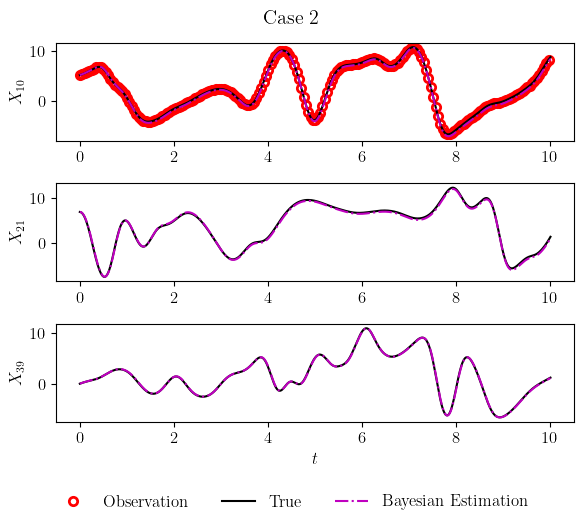

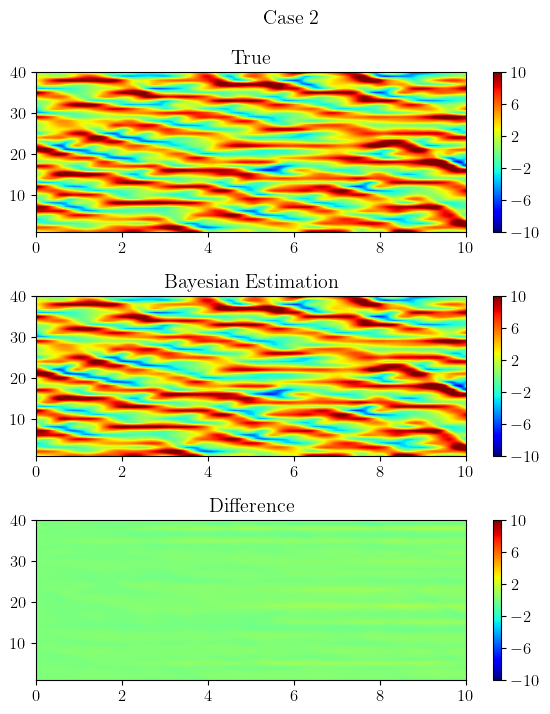

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(6,5))  # 3 subplots in a column

line_labels = ['Observation','True', 'Bayesian Estimation']

# Plot for X_10
axes[0].plot(t_steps[::5], X_state[::5, 10],'ro',fillstyle='none', markersize=6,markeredgewidth=2)
axes[0].plot(t_steps, X_state[:, 10], 'k-')
axes[0].plot(t_steps, X_state_estimated2[:, 10], 'm-.')
axes[0].set_ylabel(r'$X_{10}$')

# Plot for X_21
axes[1].plot(t_steps, X_state[:, 21], 'k-')
axes[1].plot(t_steps, X_state_estimated2[:, 21], 'm-.')
axes[1].set_ylabel(r'$X_{21}$')

# Plot for X_39
axes[2].plot(t_steps, X_state[:, 39], 'k-')
axes[2].plot(t_steps, X_state_estimated2[:, 39], 'm-.')
axes[2].set_xlabel(r'$t$')
axes[2].set_ylabel(r'$X_{39}$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlapping
# Add legend outside the subplots
fig.legend(line_labels, loc='lower center', borderaxespad=-0.2, ncol=3, labelspacing=0., frameon=False)
plt.suptitle('Case 2')
plt.show()

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(3,1,figsize=(6,7.5))

cs = ax[0].contourf(T,X,X_state.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))
ax[0].set_title('True')

cs = ax[1].contourf(T,X,X_state_estimated2.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))
ax[1].set_title('Bayesian Estimation')

diff = X_state-X_state_estimated2
cs = ax[2].contourf(T,X,(diff).T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))
ax[2].set_title('Difference')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Case 2')
plt.show()

In [13]:
# Set the observed data
X_observed = np.vstack([
    X_state[0:500, (k - 2) % N].numpy(),
    X_state[0:500, (k - 1) % N].numpy(),
    X_state[0:500, k].numpy(),
    X_state[0:500, (k + 1) % N].numpy(),
    X_state[0:500, (k + 2) % N].numpy(),
]).T
Y_observed = dx_dt_state[0:500, k].numpy()

# Convert the observed data to PyTorch tensors
X_observed = torch.tensor(X_observed)
Y_observed = torch.tensor(Y_observed)

# Define the Pyro model
def model(X_observed, Y_observed):
    N_P = 21  # Number of parameters
    d = pyro.sample("d", dist.Normal(torch.zeros(N_P), 2 * torch.ones(N_P)))
    mu = func(X_observed.T, d)
    pyro.sample("Y", dist.Normal(mu, 1.0), obs=Y_observed)

# Perform Bayesian inference with MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(X_observed, Y_observed)

# Get the posterior samples
posterior_samples3 = mcmc.get_samples()
estimated_params3 = posterior_samples3["d"].mean(dim=0)
print("Estimated parameters:", estimated_params3)

# Use the estimated parameter values
estimated_params3 = posterior_samples3["d"].mean(axis=0).numpy()

# Define the assumed dynamics with estimated parameter values
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

# Calculate the estimated RHS
RHS_estimated3 = torch.zeros((nt, N))
for k in range(N):
    RHS_estimated3[:, k] = func(
        torch.stack([
            X_state[:, (k - 2) % N],
            X_state[:, (k - 1) % N],
            X_state[:, k],
            X_state[:, (k + 1) % N],
            X_state[:, (k + 2) % N]
        ]),
        estimated_params3
    )

# Initialize X_state_estimated with the initial conditions
X_state_estimated3 = torch.zeros_like(X_state)
X_state_estimated3[0] = X_state[0]

# Numerical integration to estimate X_state_estimated
for t in range(1, nt):
    X_state_estimated3[t] = X_state_estimated3[t-1] + dt * RHS_estimated3[t-1]

Sample: 100%|██████████| 2000/2000 [29:33,  1.13it/s, step size=1.65e-02, acc. prob=0.940]

Estimated parameters: tensor([ 7.3614e+00, -5.5742e-03, -4.9458e-02, -1.4838e+00, -4.5899e-02,
         9.5715e-02, -1.0098e+00,  3.0295e-02, -7.2704e-02,  4.7082e-03,
        -3.9395e-03,  9.8268e-01,  6.8834e-02,  5.5228e-02, -2.2433e-02,
        -1.2892e-02,  4.7757e-02,  6.0749e-02,  9.5159e-02,  3.7190e-02,
         2.5174e-02], dtype=torch.float64)


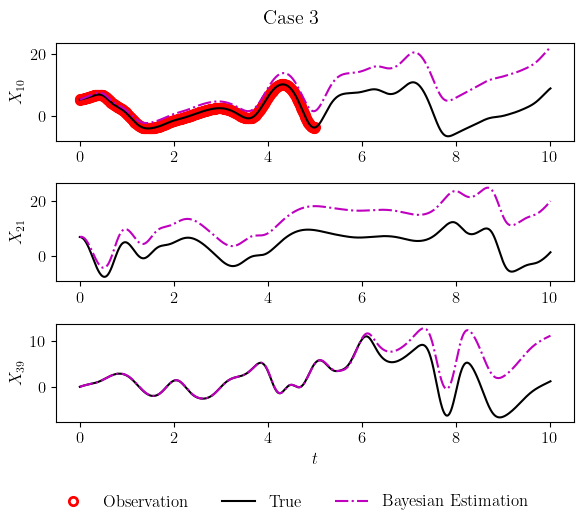

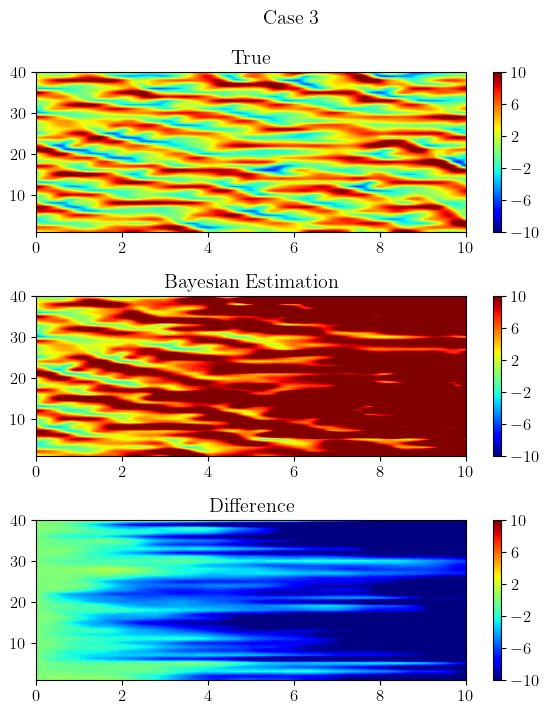

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(6,5))  # 3 subplots in a column

line_labels = ['Observation','True', 'Bayesian Estimation']

# Plot for X_10
axes[0].plot(t_steps[0:500], X_state[0:500, 10],'ro',fillstyle='none', markersize=6,markeredgewidth=2)
axes[0].plot(t_steps, X_state[:, 10], 'k-')
axes[0].plot(t_steps, X_state_estimated3[:, 10], 'm-.')
axes[0].set_ylabel(r'$X_{10}$')

# Plot for X_21
axes[1].plot(t_steps, X_state[:, 21], 'k-')
axes[1].plot(t_steps, X_state_estimated3[:, 21], 'm-.')
axes[1].set_ylabel(r'$X_{21}$')

# Plot for X_39
axes[2].plot(t_steps, X_state[:, 39], 'k-')
axes[2].plot(t_steps, X_state_estimated3[:, 39], 'm-.')
axes[2].set_xlabel(r'$t$')
axes[2].set_ylabel(r'$X_{39}$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlapping
# Add legend outside the subplots
fig.legend(line_labels, loc='lower center', borderaxespad=-0.2, ncol=3, labelspacing=0., frameon=False)
plt.suptitle('Case 3')
plt.show()

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(3,1,figsize=(6,7.5))

cs = ax[0].contourf(T,X,X_state.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))
ax[0].set_title('True')

cs = ax[1].contourf(T,X,X_state_estimated3.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))
ax[1].set_title('Bayesian Estimation')

diff = X_state-X_state_estimated3
cs = ax[2].contourf(T,X,(diff).T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))
ax[2].set_title('Difference')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Case 3')
plt.show()

Sample: 100%|██████████| 2000/2000 [25:05,  1.33it/s, step size=2.10e-02, acc. prob=0.940]


Estimated parameters: tensor([ 3.8877,  0.0050, -0.1154, -2.0585, -0.0561,  0.2111, -1.0213,  0.0647,
        -0.1680,  0.0113, -0.0075,  0.9602,  0.1564,  0.1244, -0.0517, -0.0283,
         0.1080,  0.1365,  0.2152,  0.0814,  0.0568], dtype=torch.float64)


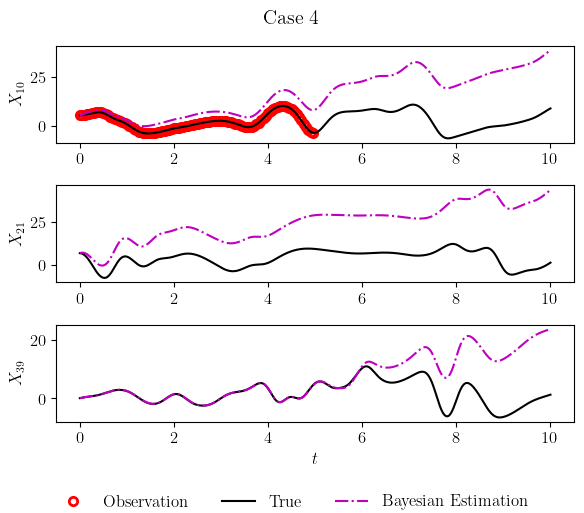

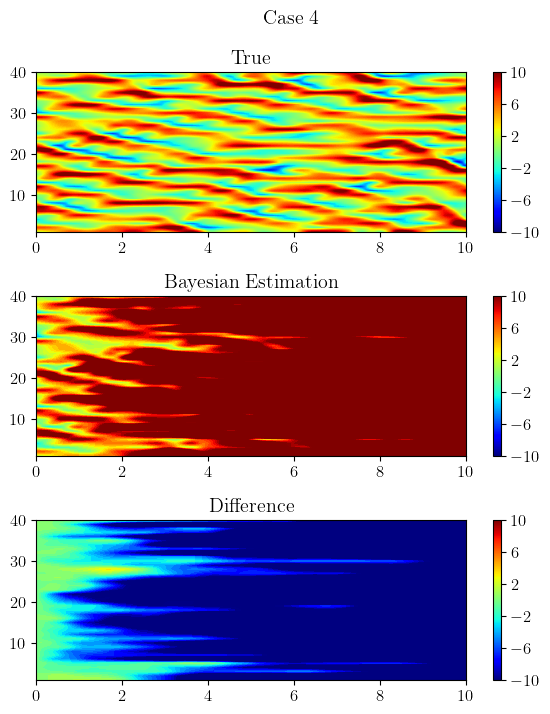

In [15]:
# Set the observed data
X_observed = np.vstack([
    X_state[0:500, (k - 2) % N][::5].numpy(),
    X_state[0:500, (k - 1) % N][::5].numpy(),
    X_state[0:500, k][::5].numpy(),
    X_state[0:500, (k + 1) % N][::5].numpy(),
    X_state[0:500, (k + 2) % N][::5].numpy(),
]).T
Y_observed = dx_dt_state[0:500, k][::5].numpy()

# Convert the observed data to PyTorch tensors
X_observed = torch.tensor(X_observed)
Y_observed = torch.tensor(Y_observed)

# Define the Pyro model
def model(X_observed, Y_observed):
    N_P = 21  # Number of parameters
    d = pyro.sample("d", dist.Normal(torch.zeros(N_P), 2 * torch.ones(N_P)))
    mu = func(X_observed.T, d)
    pyro.sample("Y", dist.Normal(mu, 1.0), obs=Y_observed)

# Perform Bayesian inference with MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(X_observed, Y_observed)

# Get the posterior samples
posterior_samples4 = mcmc.get_samples()
estimated_params4 = posterior_samples4["d"].mean(dim=0)
print("Estimated parameters:", estimated_params4)

# Use the estimated parameter values
estimated_params4 = posterior_samples4["d"].mean(axis=0).numpy()

# Define the assumed dynamics with estimated parameter values
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

# Calculate the estimated RHS
RHS_estimated4 = torch.zeros((nt, N))
for k in range(N):
    RHS_estimated4[:, k] = func(
        torch.stack([
            X_state[:, (k - 2) % N],
            X_state[:, (k - 1) % N],
            X_state[:, k],
            X_state[:, (k + 1) % N],
            X_state[:, (k + 2) % N]
        ]),
        estimated_params4
    )

# Initialize X_state_estimated with the initial conditions
X_state_estimated4 = torch.zeros_like(X_state)
X_state_estimated4[0] = X_state[0]

# Numerical integration to estimate X_state_estimated
for t in range(1, nt):
    X_state_estimated4[t] = X_state_estimated4[t-1] + dt * RHS_estimated4[t-1]

fig, axes = plt.subplots(3, 1, figsize=(6,5))  # 3 subplots in a column

line_labels = ['Observation','True', 'Bayesian Estimation']

# Plot for X_10
axes[0].plot(t_steps[0:500][::5], X_state[0:500, 10][::5],'ro',fillstyle='none', markersize=6,markeredgewidth=2)
axes[0].plot(t_steps, X_state[:, 10], 'k-')
axes[0].plot(t_steps, X_state_estimated4[:, 10], 'm-.')
axes[0].set_ylabel(r'$X_{10}$')

# Plot for X_21
axes[1].plot(t_steps, X_state[:, 21], 'k-')
axes[1].plot(t_steps, X_state_estimated4[:, 21], 'm-.')
axes[1].set_ylabel(r'$X_{21}$')

# Plot for X_39
axes[2].plot(t_steps, X_state[:, 39], 'k-')
axes[2].plot(t_steps, X_state_estimated4[:, 39], 'm-.')
axes[2].set_xlabel(r'$t$')
axes[2].set_ylabel(r'$X_{39}$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlapping
# Add legend outside the subplots
fig.legend(line_labels, loc='lower center', borderaxespad=-0.2, ncol=3, labelspacing=0., frameon=False)
plt.suptitle('Case 4')
plt.show()

#%%
vmin = -10
vmax = 10
fig, ax = plt.subplots(3,1,figsize=(6,7.5))

cs = ax[0].contourf(T,X,X_state.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))
ax[0].set_title('True')

cs = ax[1].contourf(T,X,X_state_estimated4.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))
ax[1].set_title('Bayesian Estimation')

diff = X_state-X_state_estimated4
cs = ax[2].contourf(T,X,(diff).T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))
ax[2].set_title('Difference')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Case 4')
plt.show()